In [0]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
import torch
auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

#!ln -s ~/.local/bin/kaggle /usr/bin/kaggle
print(f"CUDA is available: {torch.cuda.is_available()}")
torch.cuda.set_device(0)

from google.colab import drive
drive.mount('/content/drive')

#!pip install -q kaggle


Download 100%.
CUDA is available: True
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%%capture
!mkdir -p ~/.kaggle
!cp drive/My\ Drive/kaggle.json ~/.kaggle/
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip skin-cancer-mnist-ham10000.zip

In [0]:
%%capture
!mkdir HAM10000_images
!unzip HAM10000_images_part_1.zip -d HAM10000_images
!unzip HAM10000_images_part_2.zip -d HAM10000_images
!rm HAM10000_images_part_1.zip HAM10000_images_part_2.zip skin-cancer-mnist-ham10000.zip


In [7]:
!ls

adc.json	 HAM10000_metadata.csv	hmnist_8_8_L.csv
drive		 hmnist_28_28_L.csv	hmnist_8_8_RGB.csv
HAM10000_images  hmnist_28_28_RGB.csv	sample_data


In [0]:
import pandas as pd
import numpy as np
from scipy import fftpack
from matplotlib import pyplot as plt
import seaborn as sns
import statistics
import albumentations as alb
import os

from skimage import color, io, morphology, feature, segmentation, exposure
from glob import glob
import typing

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from skimage import io
from skimage.transform import resize
from skimage import color
from sklearn.utils import class_weight
import torchvision
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader

from skimage.exposure import rescale_intensity

import gc


In [2]:
gc.collect()
print(torch.cuda.is_available())

True


In [0]:
def rescale(image, mn=0, mx=1):
  return rescale_intensity(image,out_range=(mn,mx))

from scipy.ndimage.filters import maximum_filter, minimum_filter
def edges(image: np.ndarray,
          size: int = 3) -> typing.Any:
    ratio = np.zeros_like(image)
    if len(image.shape)>2:
        ratio = np.divide(maximum_filter(image, (size,size,size))+1,
                          minimum_filter(image, (size,size,size))+1)
    else:
        ratio = np.divide(maximum_filter(image, (size,size))+1,
                          minimum_filter(image, (size,size))+1)
    ratio = rescale(20*np.log(ratio))
    return ratio
  
def EME(image):
  return np.sum(edges(image))/image.size


def alpha_rooting_fourier(image: np.ndarray, alpha: float = 0.9) -> np.array:
    ffted = fftpack.fft2(image)
    abs_ffted = np.absolute(ffted)**alpha
    iffted = fftpack.ifft2(abs_ffted*np.divide(ffted,np.absolute(ffted), 
                                           out = np.zeros_like(ffted),
                                           where=np.absolute(ffted)!=0))
    iffted = rescale(np.absolute(iffted), 0, 1)  # .astype(int)
    return iffted

In [4]:
!ls

adc.json		HAM10000_images        hmnist_28_28_RGB.csv
cifar-10-batches-py	HAM10000_metadata.csv  hmnist_8_8_L.csv
cifar-10-python.tar.gz	harmonic_network.tar   hmnist_8_8_RGB.csv
drive			hmnist_28_28_L.csv     sample_data


In [0]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}



metadata = pd.read_csv('HAM10000_metadata.csv')
#imgs_28_rgb = pd.read_csv('hmnist_28_28_RGB.csv')

#labels = imgs_28_rgb['label'].values

#del imgs_28_rgb

#diag_by_txt = dict(zip(list(dict(metadata.dx.value_counts()).keys()),
#                       list(dict(pd.value_counts(labels)).keys())))
#diag_by_label = dict(zip(list(dict(pd.value_counts(labels)).keys()), 
#                         list(dict(metadata.dx.value_counts()).keys())))

#metadata['sex'] = pd.Categorical(metadata['sex']).codes
#metadata['label'] = metadata['dx'].map(diag_by_txt.get)
imageid_path_dict = {x: f'HAM10000_images/{x}.jpg' for x in metadata.image_id}#{os.path.splitext(os.path.basename(x))[0]: x
                     #for x in glob(os.path.join('HAM10000_images', '*.jpg'))}
#metadata['path'] = metadata['image_id'].map(imageid_path_dict.get)
#metadata['image'] = metadata['path'].map(io.imread)
#metadata['diag_name'] = metadata['dx'].map(lesion_type_dict.get) 
#metadata.head()
#del metadata

In [6]:
imageid_path_dict

{'ISIC_0027419': 'HAM10000_images/ISIC_0027419.jpg',
 'ISIC_0025030': 'HAM10000_images/ISIC_0025030.jpg',
 'ISIC_0026769': 'HAM10000_images/ISIC_0026769.jpg',
 'ISIC_0025661': 'HAM10000_images/ISIC_0025661.jpg',
 'ISIC_0031633': 'HAM10000_images/ISIC_0031633.jpg',
 'ISIC_0027850': 'HAM10000_images/ISIC_0027850.jpg',
 'ISIC_0029176': 'HAM10000_images/ISIC_0029176.jpg',
 'ISIC_0029068': 'HAM10000_images/ISIC_0029068.jpg',
 'ISIC_0025837': 'HAM10000_images/ISIC_0025837.jpg',
 'ISIC_0025209': 'HAM10000_images/ISIC_0025209.jpg',
 'ISIC_0025276': 'HAM10000_images/ISIC_0025276.jpg',
 'ISIC_0029396': 'HAM10000_images/ISIC_0029396.jpg',
 'ISIC_0025984': 'HAM10000_images/ISIC_0025984.jpg',
 'ISIC_0025767': 'HAM10000_images/ISIC_0025767.jpg',
 'ISIC_0032417': 'HAM10000_images/ISIC_0032417.jpg',
 'ISIC_0031326': 'HAM10000_images/ISIC_0031326.jpg',
 'ISIC_0025915': 'HAM10000_images/ISIC_0025915.jpg',
 'ISIC_0031029': 'HAM10000_images/ISIC_0031029.jpg',
 'ISIC_0029836': 'HAM10000_images/ISIC_0029836

In [0]:
from sklearn.preprocessing import  LabelEncoder

enc = LabelEncoder()
metadata['dx'] =enc.fit_transform(metadata['dx'])
metadata['dx_type'] =enc.fit_transform(metadata['dx_type'])
metadata['sex'] =enc.fit_transform(metadata['sex'])
metadata['localization'] =enc.fit_transform(metadata['localization'])
metadata['lesion_id'] =enc.fit_transform(metadata['lesion_id'])
#metadata = metadata.sort_values(['image_id'], ascending=True).reset_index(drop=True)
labels = metadata.dx.values
#metadata.head()


In [0]:
class Flatten(nn.Module):
  def __init__(self):
    super(Flatten, self).__init__()
    
  def forward(self, input):
    self.output_shape = input.view(input.size(0), -1).shape
    return input.view(input.size(0), -1)

In [0]:


class Loader(Dataset):
    def __init__(self,  image_path_dict, labels, image_name=None,
                 train=True, transform=None, color_space='rgb'):
        """
        Args:
            
        """
        data = list(image_path_dict.keys()) #image ids
        self.path = image_path_dict
        self.train = train
        #self.name = image_name
        self.transform = transform #augmentation transforms
        self.train_names, self.test_names, \
            self.train_labels,  self.test_labels = train_test_split(np.asarray(data),
                                                                    np.asarray(labels),
                                                                    test_size=0.2)
        self.color_transform_dict = {
            'rgb': color.rgb2rgbcie,
            'hed': color.rgb2hed,
            'hsv': color.rgb2hsv, None: None}

        if self.train:
          self.weights = class_weight.compute_class_weight('balanced', 
                                            np.unique(self.train_labels), 
                                            self.train_labels)
          if self.color_transform_dict[color_space] is not None:
                self.train_data =np.asarray([rescale(
                        resize(self.color_transform_dict[color_space](
                            rescale(io.imread(self.path[name]).astype('float32'))), #os.path.join(self.path, name)
                               (64, 64), #(150,150)
                               mode='reflect')) for name in self.train_names])
          else:
                self.train_data = np.asarray([
                    rescale(
                        resize(
                            rescale(io.imread(self.path[name]).astype('float32')),
                                    (64, 64),
                                    mode='reflect')) for name in self.train_names])
          self.train_labels = torch.from_numpy(self.train_labels)
        else:
          self.weights = class_weight.compute_class_weight('balanced', 
                                            np.unique(self.test_labels), 
                                            self.test_labels)
          if self.color_transform_dict[color_space] is not None:
                self.test_data = np.asarray([
                    rescale(
                        resize(self.color_transform_dict[color_space](
                            rescale(io.imread(self.path[name]).astype('float32'))),
                                    (64, 64),
                                    mode='reflect')) for name in self.test_names])
          else:
                self.test_data = np.asarray([
                    rescale(
                        resize(
                            rescale(io.imread(self.path[name]).astype('float32')),
                                    (64, 64),
                                    mode='reflect')) for name in self.test_names])
          self.test_labels = torch.from_numpy(self.test_labels)

    def __len__(self):
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)

    def __getitem__(self, index):
        if self.train:
          if self.transform is not None:
            image, label = ToTensor()(self.transform(**{'image':self.train_data[index]})['image']), self.train_labels[index]
          else:
            image, label = ToTensor()(self.train_data[index]), self.train_labels[index]
        else:
            image, label = ToTensor()(self.test_data[index]), self.test_labels[index]
        return image, label


In [10]:
def rescale_torch(image: torch.Tensor) -> torch.Tensor:
  return (255*(image-image.min())/(image.max()-image.min())).type(torch.uint8)

gc.collect()

22

In [0]:
trainset = Loader(imageid_path_dict,labels, train=True, transform=None)
testset = Loader(imageid_path_dict,labels, train=False, transform=None)



In [46]:
train_sampler = torch.utils.data.WeightedRandomSampler(trainset.weights[trainset.train_labels], 
                                                       len(trainset.weights[trainset.train_labels]), 
                                                       True)
test_sampler = torch.utils.data.WeightedRandomSampler(testset.weights[testset.test_labels],
                                                      len(testset.weights[testset.test_labels]), 
                                                      True)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=50,
                                          sampler = train_sampler,
                                          shuffle=False, 
                                          num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size = 50,
                                         sampler = test_sampler,
                                         shuffle = False, 
                                         num_workers =2)
gc.collect()

0

In [0]:
index = np.random.randint(1200)
image= trainloader.dataset[index][0].reshape((1,3,64,64))
label=trainloader.dataset[index][1]
id_ = trainloader.dataset.train_names[index]
plt.figure(figsize=(10,8))
plt.axis('off')
plt.grid(False)
plt.title(f'{label}')
plt.imshow(np.transpose(image[0].numpy(), (1,2,0)))

In [11]:
from torchvision.datasets import CIFAR10
cifar_train = CIFAR10('./',transform = ToTensor(), download=True, train=True)
cifar_test = CIFAR10('./', transform = ToTensor(), train=False)

trainloader_cifar = torch.utils.data.DataLoader(cifar_train, batch_size=64, #pin_memory=True,
                                          shuffle=True, num_workers=2)
testloader_cifar = torch.utils.data.DataLoader(cifar_test, batch_size = 64, #pin_memory=True,
                                         shuffle = True, num_workers =2)
gc.collect()

Files already downloaded and verified


0

In [0]:
import torch.nn.functional as F

class HarmonicBlock(nn.Module):
  def __init__(self, input_channels, output_ch, bn=True,
               kernel_size=4, lmbda = 3, pad = 0, stride = 1):
    super(HarmonicBlock, self).__init__()
    """
    :param input_channels: number of channels in the input
    :param kernel_size: size of the kernel in the filter bank
    :param pad: padding size
    :param stride: stride size
    :param lmbda: number of filters to be actually used (feature not implemented)
    """
    self.bn = bn
    self.input_channels = input_channels
    self.output_ch = output_ch
    self.pad = pad
    self.stride = stride
    self.K = kernel_size
    self.N = self.K # preferably to have N=K !! (to fully replicate the paper), this is the convolution window size
    self.PI = torch.as_tensor(np.pi)
    #self.lmbda = lmbda # limits the number of kernels
    self.conv = nn.Conv2d(in_channels = self.K**2, out_channels = self.output_ch, 
                          kernel_size = 1, 
                          padding = 0,
                          stride = 1)
    self.get_filter_bank()
    if self.bn:
      self.bnorm = nn.BatchNorm2d(self.K**2)

  
  def fltr(self, u, v, N, k):
    return torch.as_tensor([[torch.cos(torch.as_tensor(self.PI/N*(ii+0.5)*v))*torch.cos(torch.as_tensor(self.PI/N*(jj+0.5)*u)) for ii in range(k)] for jj in range(k)])
  
  
  def get_filter_bank(self):
    self.filter_bank = torch.stack([torch.stack([self.fltr(j, i, self.N, self.K) for i in range(self.K)]) for j in range(self.K)])
    self.filter_bank = self.filter_bank.reshape([1,-1,self.K,self.K])
    self.filter_bank = torch.cat([self.filter_bank]*self.input_channels, dim=0)
    self.filter_bank = torch.transpose(self.filter_bank,0,1)
    self.filter_bank = self.filter_bank.to('cuda').to(torch.float32) # without this, it does not get sent to cuda
  
  
  def forward(self, x):
    x = F.conv2d(x.to(torch.float32), weight = self.filter_bank.to(torch.float32), padding=self.pad, stride = self.stride)#int(self.K/2)
    if self.bn:
      self.bnorm
      x = self.bnorm(x)
    x = self.conv(x)      
    return x

In [57]:
def calc_output_shape(in_shape, kernel, stride, pad):
  w, h = in_shape
  w_ = (w-kernel+2*pad)/stride +1
  h_ = (h-kernel+2*pad)/stride +1
  return int(w_), int(h_)
print(calc_output_shape((64,64), 6, 1,1))
gc.collect()

(61, 61)


22

In [0]:
class HarmonicNet(nn.Module):
  def __init__(self, in_ch=3,  out_ch=32, 
               kernel_size=3,  stride=2, pad=1,
               in_shape = (64,64)):
    super(HarmonicNet, self).__init__()
    def calc_output_shape(in_shape, kernel, stride, pad):
      w, h = in_shape
      w_ = (w-kernel+2*pad)/stride +1
      h_ = (h-kernel+2*pad)/stride +1
      return int(w_), int(h_)
    
    self.input_channels = in_ch
    self.kernel_size = kernel_size
    self.stride = stride
    self.pad = pad
    self.shapes = []
    '''***'''
    self.hb1_0 = HarmonicBlock(input_channels = self.input_channels,
                               output_ch = 3,#self.input_channels,
                               kernel_size = self.kernel_size,
                               pad = self.pad,
                               stride = self.stride)
    
    shape_hb1_0 = calc_output_shape(in_shape, 
                                    self.hb1_0.K,
                                    self.hb1_0.stride,
                                    self.hb1_0.pad)
    self.shapes.append(shape_hb1_0)
    '''***'''
    self.harmonic_block1 = HarmonicBlock(input_channels = self.input_channels,
                                         output_ch = out_ch,
                                         kernel_size = self.kernel_size, 
                                         pad = self.pad, 
                                         stride = self.stride)
    
    shape_harmonic_block1 = calc_output_shape(shape_hb1_0, 
                                    self.harmonic_block1.K,
                                    self.harmonic_block1.stride,
                                    self.harmonic_block1.pad)
    self.shapes.append(shape_harmonic_block1)
    '''***'''
    self.hb1_1 = HarmonicBlock(input_channels = out_ch,
                               output_ch = out_ch,
                               kernel_size = 3,
                               pad = 0,
                               stride = 2)
    
    shape_hb1_1 = calc_output_shape(shape_harmonic_block1, 
                                    self.hb1_1.K,
                                    self.hb1_1.stride,
                                    self.hb1_1.pad)
    self.shapes.append(shape_hb1_1)
    '''***'''
    self.harmonic_block2 = HarmonicBlock(input_channels = out_ch,
                                         output_ch = 64,
                                         kernel_size = 3,
                                         pad = 2,
                                         stride = 1)
    shape_harmonic_block2 = calc_output_shape(shape_hb1_1, 
                                    self.harmonic_block2.K,
                                    self.harmonic_block2.stride,
                                    self.harmonic_block2.pad)
    self.shapes.append(shape_harmonic_block2)
    '''***'''
    self.hb1_2 = HarmonicBlock(input_channels = 64,
                               output_ch = 64,
                               kernel_size = 3,
                               pad = 0,
                               stride = 2)
    shape_hb1_2 = calc_output_shape(shape_harmonic_block2, 
                                    self.hb1_2.K,
                                    self.hb1_2.stride,
                                    self.hb1_2.pad)
    self.shapes.append(shape_hb1_2)
    '''***'''
    self.harmonic_block3 = HarmonicBlock(input_channels = 64,
                                         output_ch = 128,
                                         kernel_size = 3,
                                         pad = 2,
                                         stride = 1)
    shape_harmonic_block3 = calc_output_shape(shape_hb1_2, 
                                    self.harmonic_block3.K,
                                    self.harmonic_block3.stride,
                                    self.harmonic_block3.pad)
    self.shapes.append(shape_harmonic_block3)
    '''***'''
    self.hb1_3 = HarmonicBlock(input_channels = 128,
                               output_ch = 128,
                               kernel_size = 3, 
                               pad = 1, 
                               stride = 1)
    shape_hb1_3 = calc_output_shape(shape_harmonic_block3, 
                                    self.hb1_3.K,
                                    self.hb1_3.stride,
                                    self.hb1_3.pad)
    self.shapes.append(shape_hb1_3)
    '''***'''
    self.pooling = nn.MaxPool2d(3,2)
    shape_pool = calc_output_shape(shape_hb1_3, 3,2,0)
    self.shapes.append(shape_pool)
    '''***'''
    self.flatten = Flatten()
    self.linear1 = nn.Linear(128*shape_pool[0]*shape_pool[1], 1024)
    self.linear2 = nn.Linear(1024, 128)
    self.linear3 = nn.Linear(128, 10)
    self.dropout = nn.Dropout(0.5)
    self.activation = nn.ReLU()
    self.softmax = nn.LogSoftmax()
    self.sigmoid = nn.Sigmoid()
    self.tanh = nn.Tanh()
    
    
    
  
  def rescale_torch(self, image: torch.Tensor) -> torch.Tensor:
    return (1.*(image-image.min())/(image.max()-image.min())).type(torch.float32)
  
  
  def calc_output_shape(in_shape, kernel, stride, pad):
    w, h = in_shape
    w_ = (w-kernel+2*pad)/stride +1
    h_ = (h-kernel+2*pad)/stride +1
    return int(w_), int(h_)

  
  def forward(self, x):
    x = self.hb1_0(x)
    x = self.activation(x)
    x = self.harmonic_block1(x)
    x = self.activation(x)
    x = self.hb1_1(x)
    x = self.activation(x)
    x = self.harmonic_block2(x)
    x = self.activation(x)
    x = self.hb1_2(x)
    x = self.activation(x)
    x = self.harmonic_block3(x)
    x = self.activation(x)
    x = self.hb1_3(x)
    x = self.activation(x)
    x = self.pooling(x)
    x = self.flatten(x)
    x = self.linear1(x)
    x = self.activation(x)
    x = self.dropout(x)
    x = self.linear2(x)
    x = self.activation(x)
    x = self.dropout(x)
    x = self.linear3(x)
    #x = torch.clamp( x.atan_(), 0, 1)
    #x = (self.tanh(x) + 1)/2
    #x = self.softmax(x)
    #x = torch.clamp(self.sigmoid(x)**(0.99), 0, 1)
    x = x.view(-1, 10)
    
    return x

In [44]:
calc_output_shape((64,64),6,1,3)

(65, 65)

In [0]:
image= trainloader.dataset[1250][0].reshape((1,3,64,64))
#x =image
plt.figure(figsize=(10,8))
plt.axis('off')
plt.grid(False)
plt.imshow(np.transpose(image[0].numpy(), (1,2,0)))
print(f"Original shape {image.shape}\n")
model_harmonic = HarmonicNet(3,32).cuda()
x = model_harmonic.hb1_0(image.to('cuda'))
print(f"hb1_0 shape {x.shape}\n")
plt.figure(figsize=(10,8))
plt.axis('off')
plt.grid(False)
plt.imshow(np.transpose(x[0].detach().cpu().numpy(), (1,2,0)))
x = model_harmonic.harmonic_block1(x)
print(f"Harmonic block 1 shape {x.shape}\n")
fig, ax = plt.subplots(nrows = 4, ncols=8, figsize=(20,12))
count=0
for i in range(4):
    for j in range(8):
      ax[i,j].imshow(x[0,count,:,:].detach().cpu().numpy())
      ax[i,j].grid(False)
      ax[i,j].axis('off')
      count+=1

x = model_harmonic.hb1_1(x)      
print(f"hb1_1 shape {x.shape}\n")
count=0
fig, ax = plt.subplots(nrows = 4, ncols=8, figsize=(20,12))
for i in range(4):
    for j in range(8):
      ax[i,j].imshow(x[0,count,:,:].detach().cpu().numpy())
      ax[i,j].grid(False)
      ax[i,j].axis('off')
      count+=1
x = model_harmonic.harmonic_block2(x)
print(f"Harmonic block 2 shape {x.shape}\n")
x = model_harmonic.hb1_2(x)
print(f"hb1_2 shape {x.shape}\n")
x = model_harmonic.harmonic_block3(x)
print(f"Harmonic block 3 shape {x.shape}\n")
x = model_harmonic.hb1_3(x)
print(f"hb1_3 shape {x.shape}\n")
x = model_harmonic.pooling(x)
print(f"pooling shape {x.shape}\n")
count=0

gc.collect()

In [38]:
model_harmonic = HarmonicNet(3,32,4,1,2,in_shape=(32,32))
model_harmonic.shapes

[(33, 33), (34, 34), (16, 16), (18, 18), (8, 8), (10, 10), (10, 10), (4, 4)]

In [39]:
model_harmonic = HarmonicNet(3,32,4,1,1,(32,32))


for module in model_harmonic.modules():
  if isinstance(module, nn.Conv2d):
    module.weight.data.normal_(0,0.05)
    module.bias.data.zero_()

model_harmonic = model_harmonic.to('cuda')
for parameter in model_harmonic.parameters():
  parameter.to('cuda')
model_harmonic.cuda()
model_harmonic = torch.nn.DataParallel(model_harmonic, device_ids=range(torch.cuda.device_count()))
base_lr = 0.01
param_dict = dict(model_harmonic.named_parameters())
params = []

criterion = nn.CrossEntropyLoss()#BCEWithLogitsLoss()#MultiLabelSoftMarginLoss()#BCELoss with tanh, atan
              #MultiLabelSoftMarginLoss()
              #BCEWithLogitsLoss()
              
optimizer = optim.Adam(model_harmonic.parameters(),
                       #eps=1e-5,
                       lr=base_lr, 
                       weight_decay=0.)

#device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc=0

gc.collect()


629

In [0]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


def one_hot_enc(output, target, num_classes=7):
  labels = target.view((-1,1))
  batch_size, _= labels.size()
  labels_one_hot = torch.FloatTensor(batch_size, num_classes).zero_().to('cuda')
  labels_one_hot.scatter_(1, labels, 1)
  return labels_one_hot


def train(epoch, model):
  model.train()
  #w = trainloader.dataset.weights
  corrects = 0.0
  f1 = 0.0
  prec = 0.0
  rec = 0.0
  iteration = 0
  #criterion.weight = torch.from_numpy(trainset.weights).to('cuda').type(torch.float)
  for batch_idx, (data, label) in enumerate(trainloader_cifar):
    data, label = torch.autograd.Variable(data.cuda()), torch.autograd.Variable(label.cuda())
    optimizer.zero_grad()
    output = model(data)
    label_ = label#one_hot_enc(output, label)
    loss = criterion(output, label_)
    y_pred = torch.max(output, 1)[1]
    loss.backward()
    optimizer.step()
    corrects += y_pred.eq(label.data).cpu().sum()
    f1 += f1_score(y_true=label.data.cpu().numpy(),
                   y_pred=y_pred.cpu().numpy(),
                   average='micro')
    prec += precision_score(y_true=label.data.cpu().numpy(),
                            y_pred=y_pred.cpu().numpy(),
                            average='micro')
    rec += recall_score(y_true=label.data.cpu().numpy(),
                         y_pred=y_pred.cpu().numpy(),
                         average='micro')
    iteration+=1
  acc = 100. * corrects / len(trainloader_cifar.dataset)
  f1 = f1/iteration
  prec = prec/iteration
  rec = rec/iteration
  train_losses.append(loss.data.item())
  train_accs.append(acc)
  print(f"\tTraining accuracy = {acc:.2f}%; F1 = {100.*f1:.2f}%; Precision = {100.*prec:.2f}%; Recall = {100.*rec:.2f}%\n")

def test(epoch, model):
  global best_acc
  model.eval()
  #w = testloader.dataset.weights
  acc = 0.0
  f1 = 0.0
  prec = 0.0
  rec = 0.0
  iteration = 0
  testloss = 0.0
  corrects = 0.0
  #criterion.weight = torch.from_numpy(testset.weights).to('cuda').type(torch.float)
  for batch_id, (data, label) in enumerate(testloader_cifar):
    with torch.no_grad():
      data, label = torch.autograd.Variable(data).cuda(), torch.autograd.Variable(label).cuda()
      output = model(data)
      label_ = label#one_hot_enc(output, label) # one hot encoding for loss function
      loss = criterion(output, label_)
      y_pred = torch.max(output, 1)[1]
      corrects += y_pred.eq(label.data).cpu().sum()
      testloss += loss
      f1 += f1_score(y_true=label.data.cpu().numpy(),
                   y_pred=y_pred.cpu().numpy(),
                   average='micro')
      prec += precision_score(y_true=label.data.cpu().numpy(),
                            y_pred=y_pred.cpu().numpy(),
                            average='micro')
      rec += recall_score(y_true=label.data.cpu().numpy(),
                         y_pred=y_pred.cpu().numpy(),
                         average='micro')
    iteration+=1
  acc = 100. * corrects / len(testloader_cifar.dataset)
  f1 = f1/iteration
  prec = prec/iteration
  rec = rec/iteration
  testloss /= len(testloader_cifar.dataset)
  if best_acc < acc.item():
    best_acc = acc
    save_state(model, best_acc)
  print(f"\tTesting accuracy = {acc:.2f}%; F1 = {100.*f1:.2f}%; Precision = {100.*prec:.2f}%; Recall = {100.*rec:.2f}% \n\tLoss: {testloss:1.2e}\n")  
  test_losses.append(loss.data.item())
  test_accs.append(acc)
def adjust_learning_rate(optimizer, epoch):
  update_list = [i for i in range(0,150,10)]
  if epoch in update_list:
    for param_group in optimizer.param_groups:
            param_group['lr'] = max(param_group['lr'] * 0.1, 1e-8)
  return 

def save_state(model, best_acc):
  print('\n==> Saving model ...')
  state = {'best_acc': best_acc,
             'state_dict': model.state_dict()}
  keys = list(state['state_dict'].keys())
  for key in keys:
    if 'module' in key:
      state['state_dict'][key.replace('module.', '')] = \
                    state['state_dict'].pop(key)
  torch.save(state, 'harmonic_network.tar')

train_losses = []
train_accs = []
test_losses = []
test_accs = []

from IPython.display import clear_output
clear_output()

def get_lr(optimizer=optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


In [41]:
for epoch in range(300):
  #adjust_learning_rate(optimizer, epoch)
  lr = get_lr()
  print(f" Epoch: {epoch}, learning rate = {lr:1.2e};\n")
  
  train(epoch, model_harmonic)
  
  test(epoch, model_harmonic)
  gc.collect()




 Epoch: 0, learning rate = 1.00e-02;

	Training accuracy = 20.00%; F1 = 20.78%; Precision = 20.78%; Recall = 20.78%


==> Saving model ...
	Testing accuracy = 24.00%; F1 = 24.14%; Precision = 24.14%; Recall = 24.14% 
	Loss: 2.99e-02

 Epoch: 1, learning rate = 1.00e-02;

	Training accuracy = 24.00%; F1 = 24.04%; Precision = 24.04%; Recall = 24.04%


==> Saving model ...
	Testing accuracy = 25.00%; F1 = 25.46%; Precision = 25.46%; Recall = 25.46% 
	Loss: 2.94e-02

 Epoch: 2, learning rate = 1.00e-02;

	Training accuracy = 24.00%; F1 = 24.69%; Precision = 24.69%; Recall = 24.69%

	Testing accuracy = 25.00%; F1 = 25.13%; Precision = 25.13%; Recall = 25.13% 
	Loss: 3.02e-02

 Epoch: 3, learning rate = 1.00e-02;

	Training accuracy = 25.00%; F1 = 25.16%; Precision = 25.16%; Recall = 25.16%


==> Saving model ...
	Testing accuracy = 27.00%; F1 = 27.51%; Precision = 27.51%; Recall = 27.51% 
	Loss: 2.89e-02

 Epoch: 4, learning rate = 1.00e-02;

	Training accuracy = 25.00%; F1 = 25.28%; Precis

Exception ignored in: <bound method Image.__del__ of <PIL.Image.Image image mode= size=0x0 at 0x7F84AD0AD390>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/PIL/Image.py", line 568, in __del__
    def __del__(self):
KeyboardInterrupt


KeyboardInterrupt: ignored

In [0]:
!mv harmonic_network.tar drive/My\ Drive/harmonic_network_shapes_work.tar

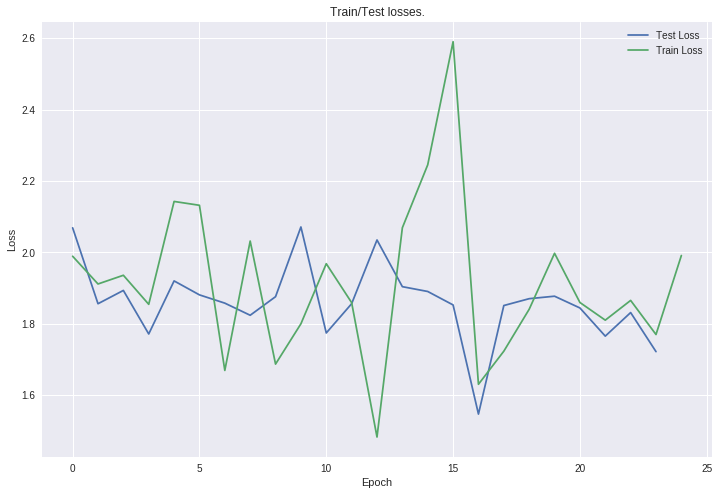

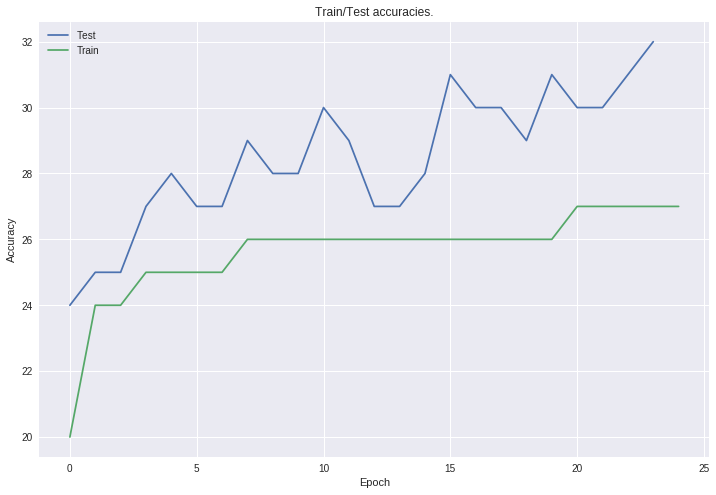

In [42]:
plt.figure(figsize = (12,8))
plt.plot(test_losses, label = "Test Loss")
plt.plot(train_losses, label = "Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Train/Test losses.") #" \nTraining accuracy = 81.00%; F1 = 81.50%; Precision = 81.50%; Recall = 81.50%\nTesting accuracy = 73.00%; F1 = 73.06%; Precision = 73.06%; Recall = 73.06%")  
plt.legend()
plt.figure(figsize = (12,8))
plt.plot(test_accs, label = "Test")
plt.plot(train_accs, label = "Train")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Train/Test accuracies.")
plt.legend()


In [98]:
model_harmonic.eval()
index = np.random.randint(len(trainloader.dataset))
image= trainloader.dataset[index][0].reshape((1,3,64,64)).to('cuda')
label=trainloader.dataset[index][1]
print(model_harmonic(image).data.max(1,keepdim=True)[1])
print(label)

tensor([[5]], device='cuda:0')
tensor(5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original shape torch.Size([1, 3, 64, 64])

hb1_0 shape torch.Size([1, 3, 64, 64])

Harmonic block 1 shape torch.Size([1, 32, 64, 64])

hb1_1 shape torch.Size([1, 32, 31, 31])

Harmonic block 2 shape torch.Size([1, 64, 33, 33])

hb1_2 shape torch.Size([1, 64, 16, 16])

Harmonic block 3 shape torch.Size([1, 128, 18, 18])

hb1_3 shape torch.Size([1, 128, 18, 18])

pooling shape torch.Size([1, 128, 8, 8])



0

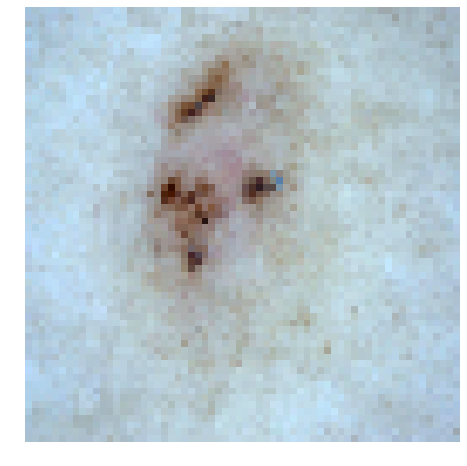

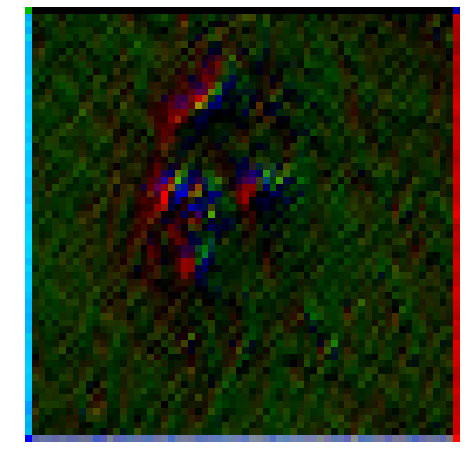

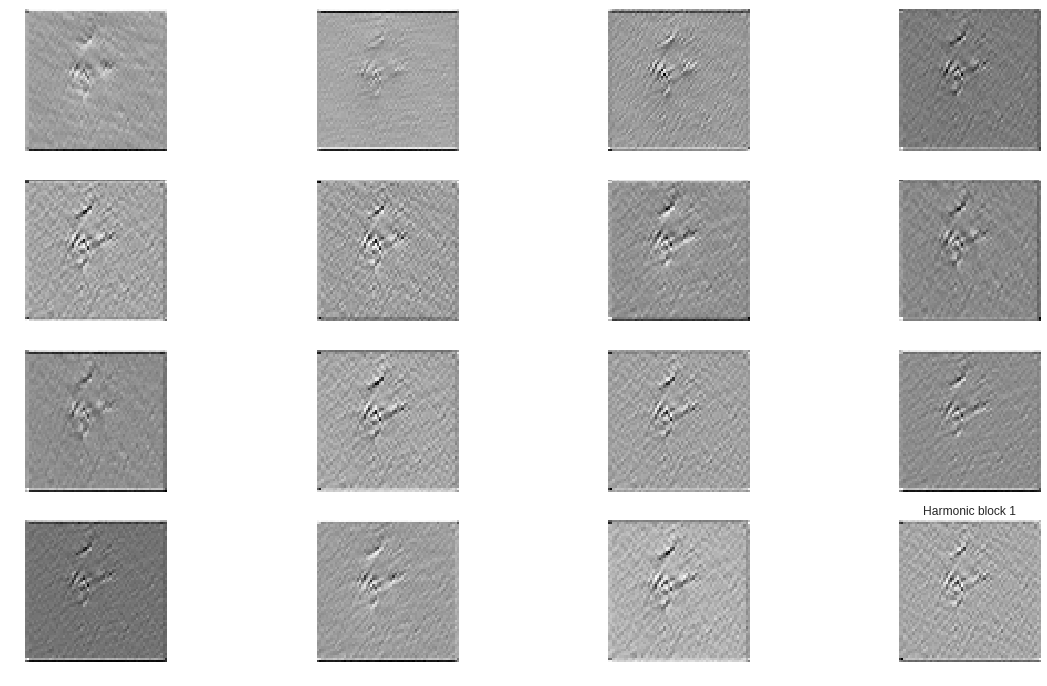

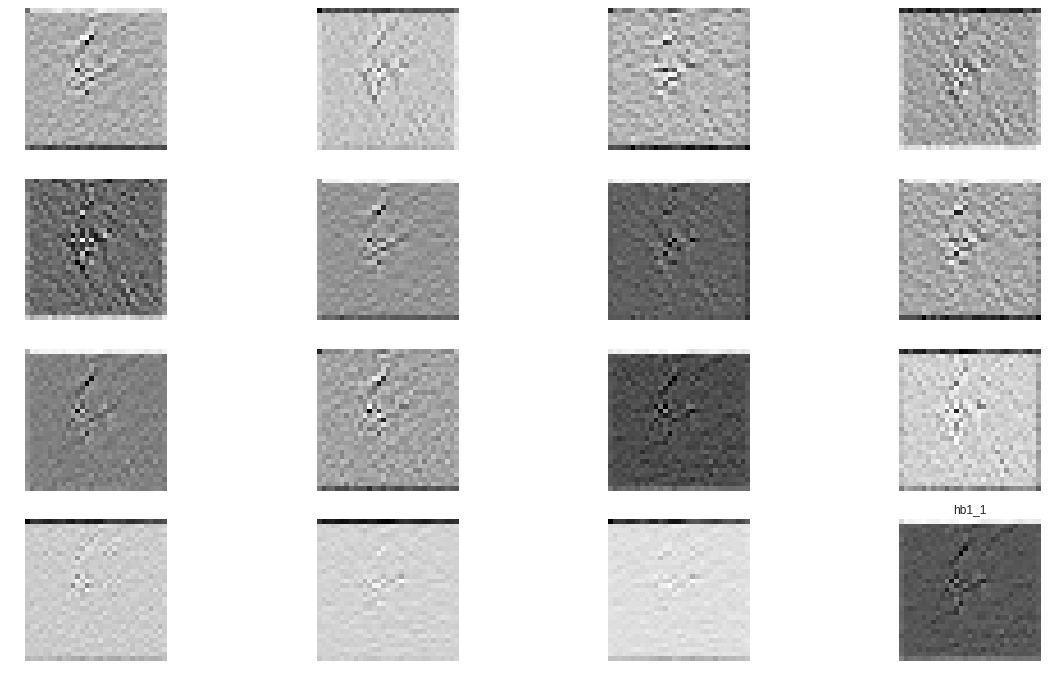

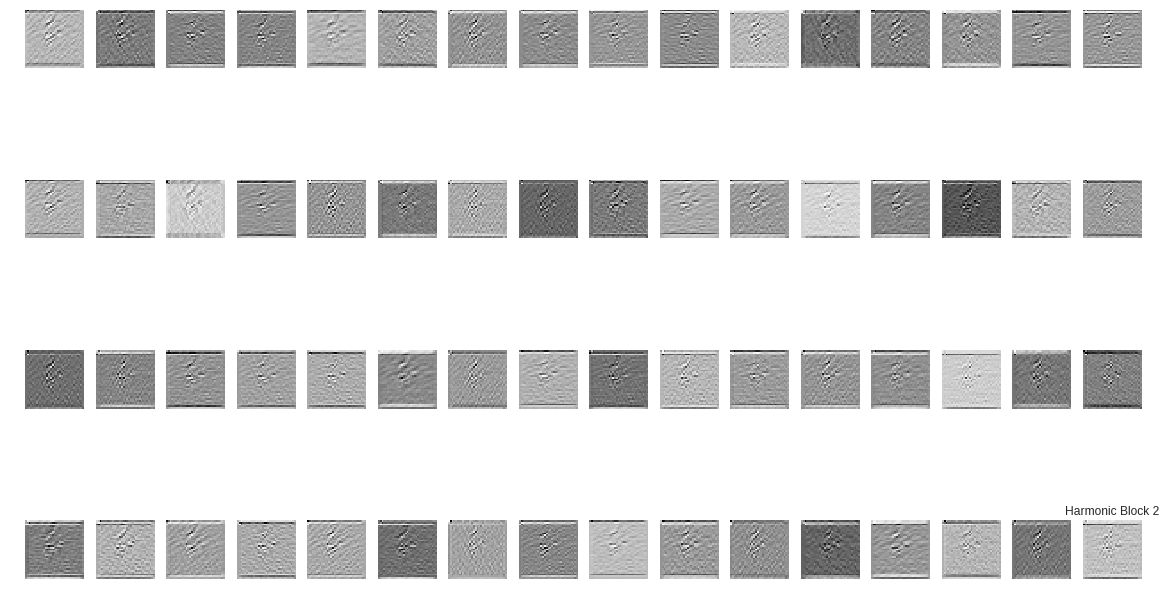

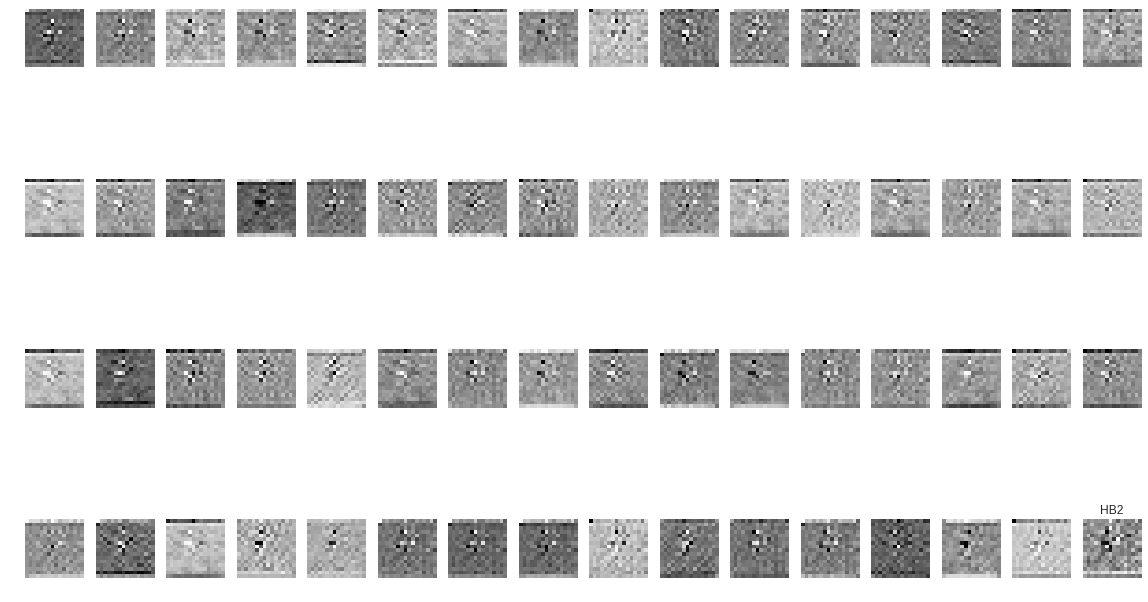

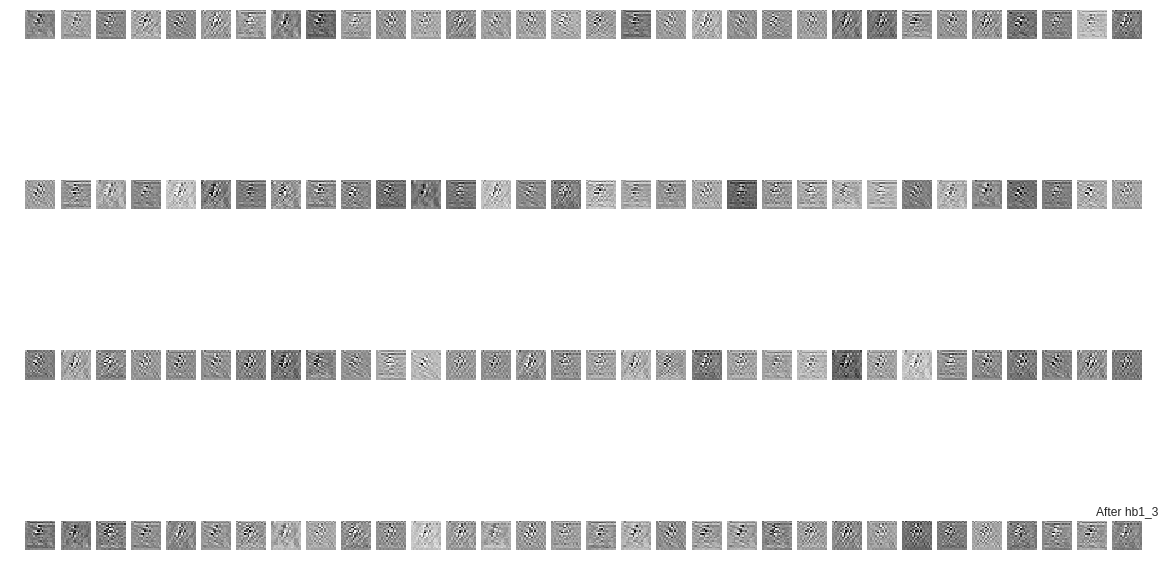

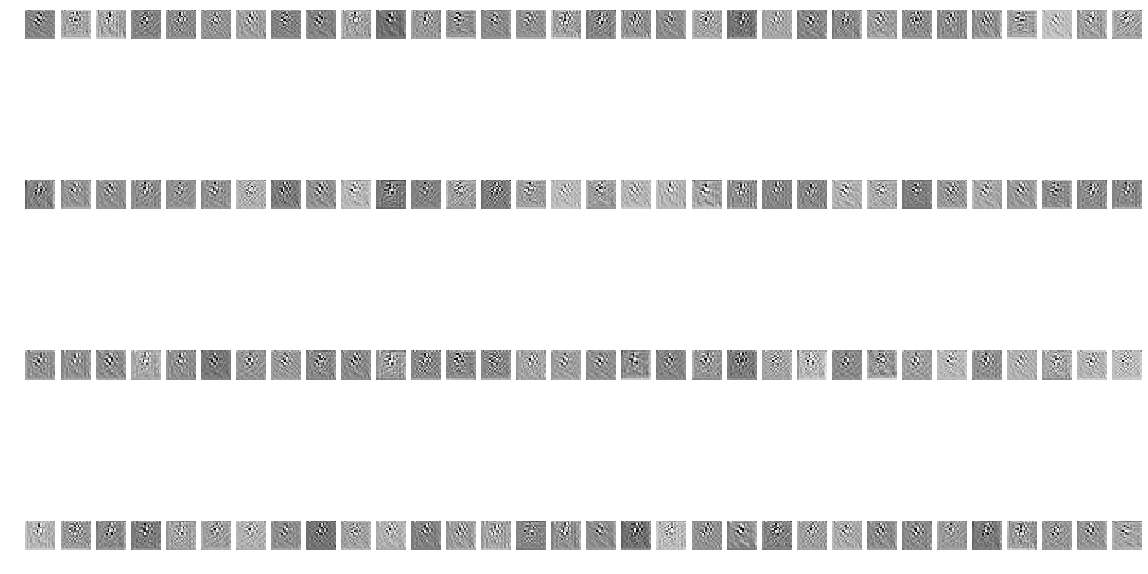

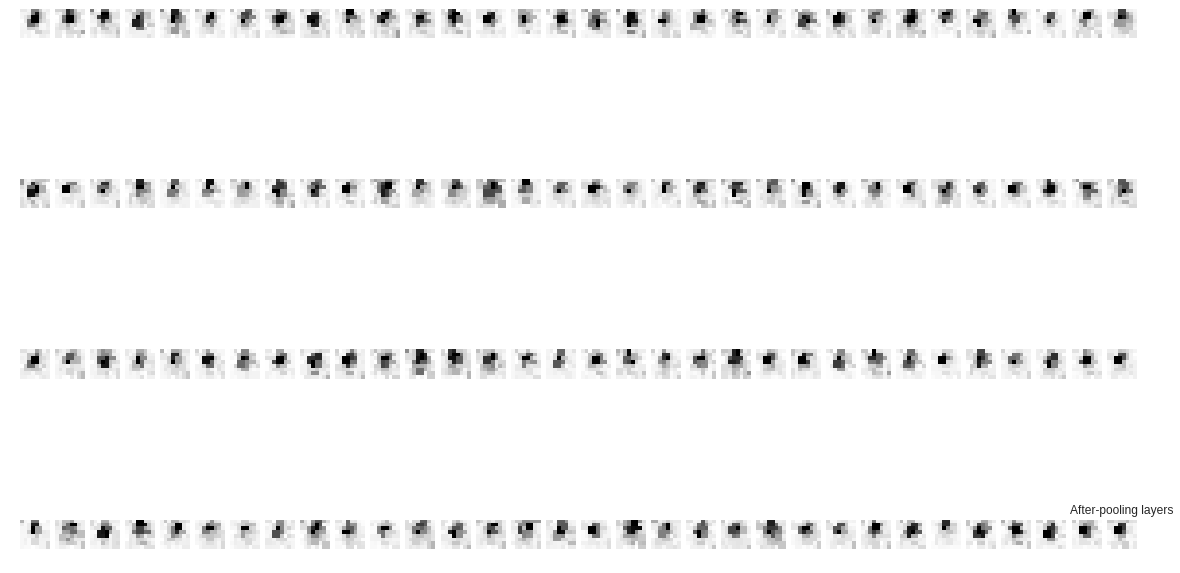

In [85]:
image= trainloader.dataset[1250][0].reshape((1,3,64,64))
#x =image
plt.figure(figsize=(10,8))
plt.axis('off')
plt.grid(False)
plt.imshow(np.transpose(image[0].numpy(), (1,2,0)))
print(f"Original shape {image.shape}\n")
x = model_harmonic.module.hb1_0(image.to('cuda'))
print(f"hb1_0 shape {x.shape}\n")
plt.figure(figsize=(10,8))
plt.axis('off')
plt.grid(False)
plt.imshow(np.transpose(x[0].detach().cpu().numpy(), (1,2,0)))
x = model_harmonic.module.harmonic_block1(x)
print(f"Harmonic block 1 shape {x.shape}\n")
fig, ax = plt.subplots(nrows = 4, ncols=4, figsize=(20,12))
plt.title('Harmonic block 1')
count=0
for i in range(4):
    for j in range(4):
      ax[i,j].imshow(x[0,count,:,:].detach().cpu().numpy())
      ax[i,j].grid(False)
      ax[i,j].axis('off')
      count+=1

x = model_harmonic.module.hb1_1(x)      
print(f"hb1_1 shape {x.shape}\n")
count=0
fig, ax = plt.subplots(nrows = 4, ncols=4, figsize=(20,12))
plt.title("hb1_1")
for i in range(4):
    for j in range(4):
      ax[i,j].imshow(x[0,count,:,:].detach().cpu().numpy())
      ax[i,j].grid(False)
      ax[i,j].axis('off')
      count+=1
x = model_harmonic.module.harmonic_block2(x)
print(f"Harmonic block 2 shape {x.shape}\n")
count=0
fig, ax = plt.subplots(nrows = 4, ncols=16, figsize=(20,12))
plt.title("Harmonic Block 2")
for i in range(4):
    for j in range(16):
      ax[i,j].imshow(x[0,count,:,:].detach().cpu().numpy())
      ax[i,j].grid(False)
      ax[i,j].axis('off')
      count+=1
x = model_harmonic.module.hb1_2(x)
print(f"hb1_2 shape {x.shape}\n")
count=0

fig, ax = plt.subplots(nrows = 4, ncols=16, figsize=(20,12))
plt.title("HB2")
for i in range(4):
    for j in range(16):
      ax[i,j].imshow(x[0,count,:,:].detach().cpu().numpy())
      ax[i,j].grid(False)
      ax[i,j].axis('off')
      count+=1
x = model_harmonic.module.harmonic_block3(x)
print(f"Harmonic block 3 shape {x.shape}\n")
count=0

fig, ax = plt.subplots(nrows = 4, ncols=32, figsize=(20,12))
plt.title("Harmonic Block 3")
for i in range(4):
    for j in range(32):
      ax[i,j].imshow(x[0,count,:,:].detach().cpu().numpy())
      ax[i,j].grid(False)
      ax[i,j].axis('off')
      count+=1
x = model_harmonic.module.hb1_3(x)
print(f"hb1_3 shape {x.shape}\n")
count=0
plt.title('After hb1_3')
fig, ax = plt.subplots(nrows = 4, ncols=32, figsize=(20,12))
for i in range(4):
    for j in range(32):
      ax[i,j].imshow(x[0,count,:,:].detach().cpu().numpy())
      ax[i,j].grid(False)
      ax[i,j].axis('off')
      count+=1
x = model_harmonic.module.pooling(x)
print(f"pooling shape {x.shape}\n")
count=0
fig, ax = plt.subplots(nrows = 4, ncols=32, figsize=(20,12))
plt.title('After-pooling layers')
for i in range(4):
    for j in range(32):
      ax[i,j].imshow(x[0,count,:,:].detach().cpu().numpy())
      ax[i,j].grid(False)
      ax[i,j].axis('off')
      count+=1
gc.collect()

In [122]:
class WeightedSumLoss(nn)

0.6694957563654518